Aproach-We have data of different indicator on which air quality index depends,but doesnt have air quality index,So I am predicting the sequence for one factor which is one of the most important indicator for air quality index.

Models used -

*   gemma:7b (llm)-doing zero shot time series forcating by using gemma:7b
    by prompting model to find a pattern in the sequence of PM2.5 and predicting the future.

*   LSTM-doing multivariate time series analysis by creating a window
    using all the 16 features and predicting the next value of PM2.5.

*   ARIMA MODEL- using the statistical approach of autoregressive        integrated moving average for predicting the next PM2.5 value.






   






Installing the required packages.

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Downloading ollama...
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
!pip install langchain-community

In [117]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.5 MB/s eta 0:00:00


In [121]:
!pip install statsmodels

Importing required libraries.

In [122]:
from langchain_community.llms import Ollama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
import pmdarima
from pmdarima import auto_arima
import statsmodels.tsa.api as smt

Data Preprocessing

In [ ]:
data=pd.read_csv("AshokVihar_Hourly.csv")

In [ ]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day','hour']])

In [ ]:
data=data.drop(['Unnamed: 0'],axis=1)

In [ ]:
data=data.drop(['year','month','day','hour'],axis=1)

In [ ]:
data.head()

,PM2.5,PM10,AT,BP,SR,RH,WS,WD,NO,NO2,SO2,Ozone,CO,Benzene,NH3,NOx,date
0,77.0,274.0,34.51,975.17,2.00,62.17,7.42,129.0,3.21,23.36,10.93,98.13,0.53,5.14,43.00,26.55,2018-06-01 00:00:00
1,75.0,237.0,34.05,976.08,2.00,62.33,7.43,129.0,2.93,21.71,9.48,97.80,0.51,3.94,47.82,24.64,2018-06-01 01:00:00
2,81.0,219.0,33.12,991.25,2.00,65.00,7.43,129.0,2.27,11.90,1.68,46.27,0.12,4.55,10.64,15.24,2018-06-01 02:00:00
3,70.0,217.0,32.54,998.50,2.00,66.92,7.42,129.0,1.72,10.70,2.97,35.88,0.30,4.20,13.44,42.32,2018-06-01 03:00:00
4,74.0,226.0,31.93,997.90,2.08,69.83,7.41,129.0,1.83,32.49,2.73,26.55,0.39,3.32,8.48,44.78,2018-06-01 04:00:00


In [ ]:
data["PM2.5"]

0        77.00
1        75.00
2        81.00
3        70.00
4        74.00
         ...  
11700    34.50
11701    37.50
11702    41.25
11703    39.00
11704    39.25
Name: PM2.5, Length: 11705, dtype: float64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11705 entries, 0 to 11704
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   PM2.5    11705 non-null  float64       
 1   PM10     11705 non-null  float64       
 2   AT       11705 non-null  float64       
 3   BP       11705 non-null  float64       
 4   SR       11705 non-null  float64       
 5   RH       11705 non-null  float64       
 6   WS       11705 non-null  float64       
 7   WD       11705 non-null  float64       
 8   NO       11705 non-null  float64       
 9   NO2      11705 non-null  float64       
 10  SO2      11705 non-null  float64       
 11  Ozone    11705 non-null  float64       
 12  CO       11705 non-null  float64       
 13  Benzene  11705 non-null  float64       
 14  NH3      11705 non-null  float64       
 15  NOx      11705 non-null  float64       
 16  date     11705 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1



*   There are no nan values and data is already cleaned and preprocessed.



Now analysing the data and checking whether it is a time series data or not.

<ipython-input-30-5eaa72cc982e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap_data = data.corr()


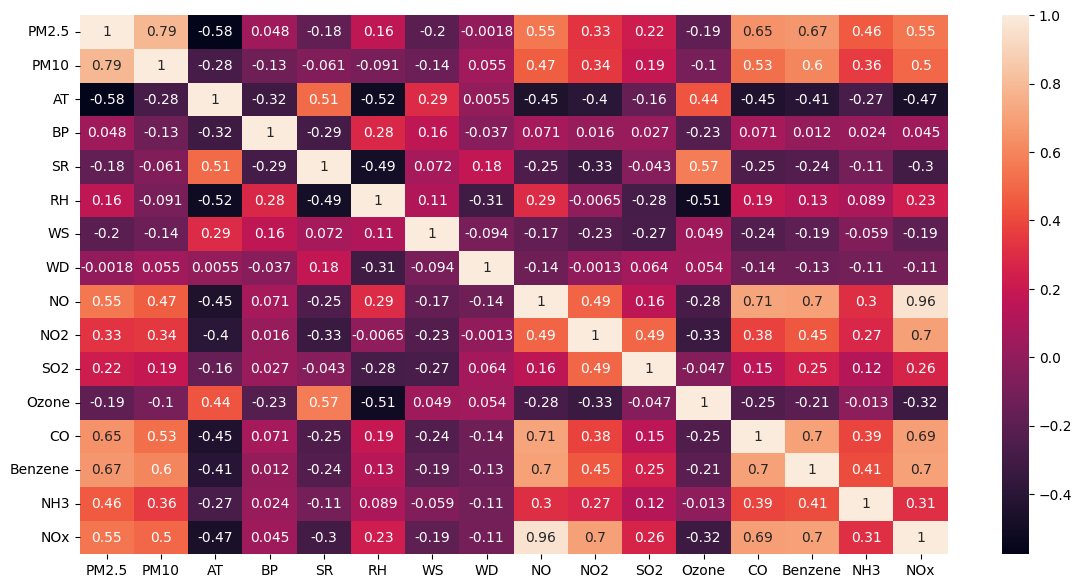

In [ ]:
heatmap_data = data.corr()
plt.figure(figsize = (14, 7))
sns.heatmap(heatmap_data, annot = True)
plt.show()

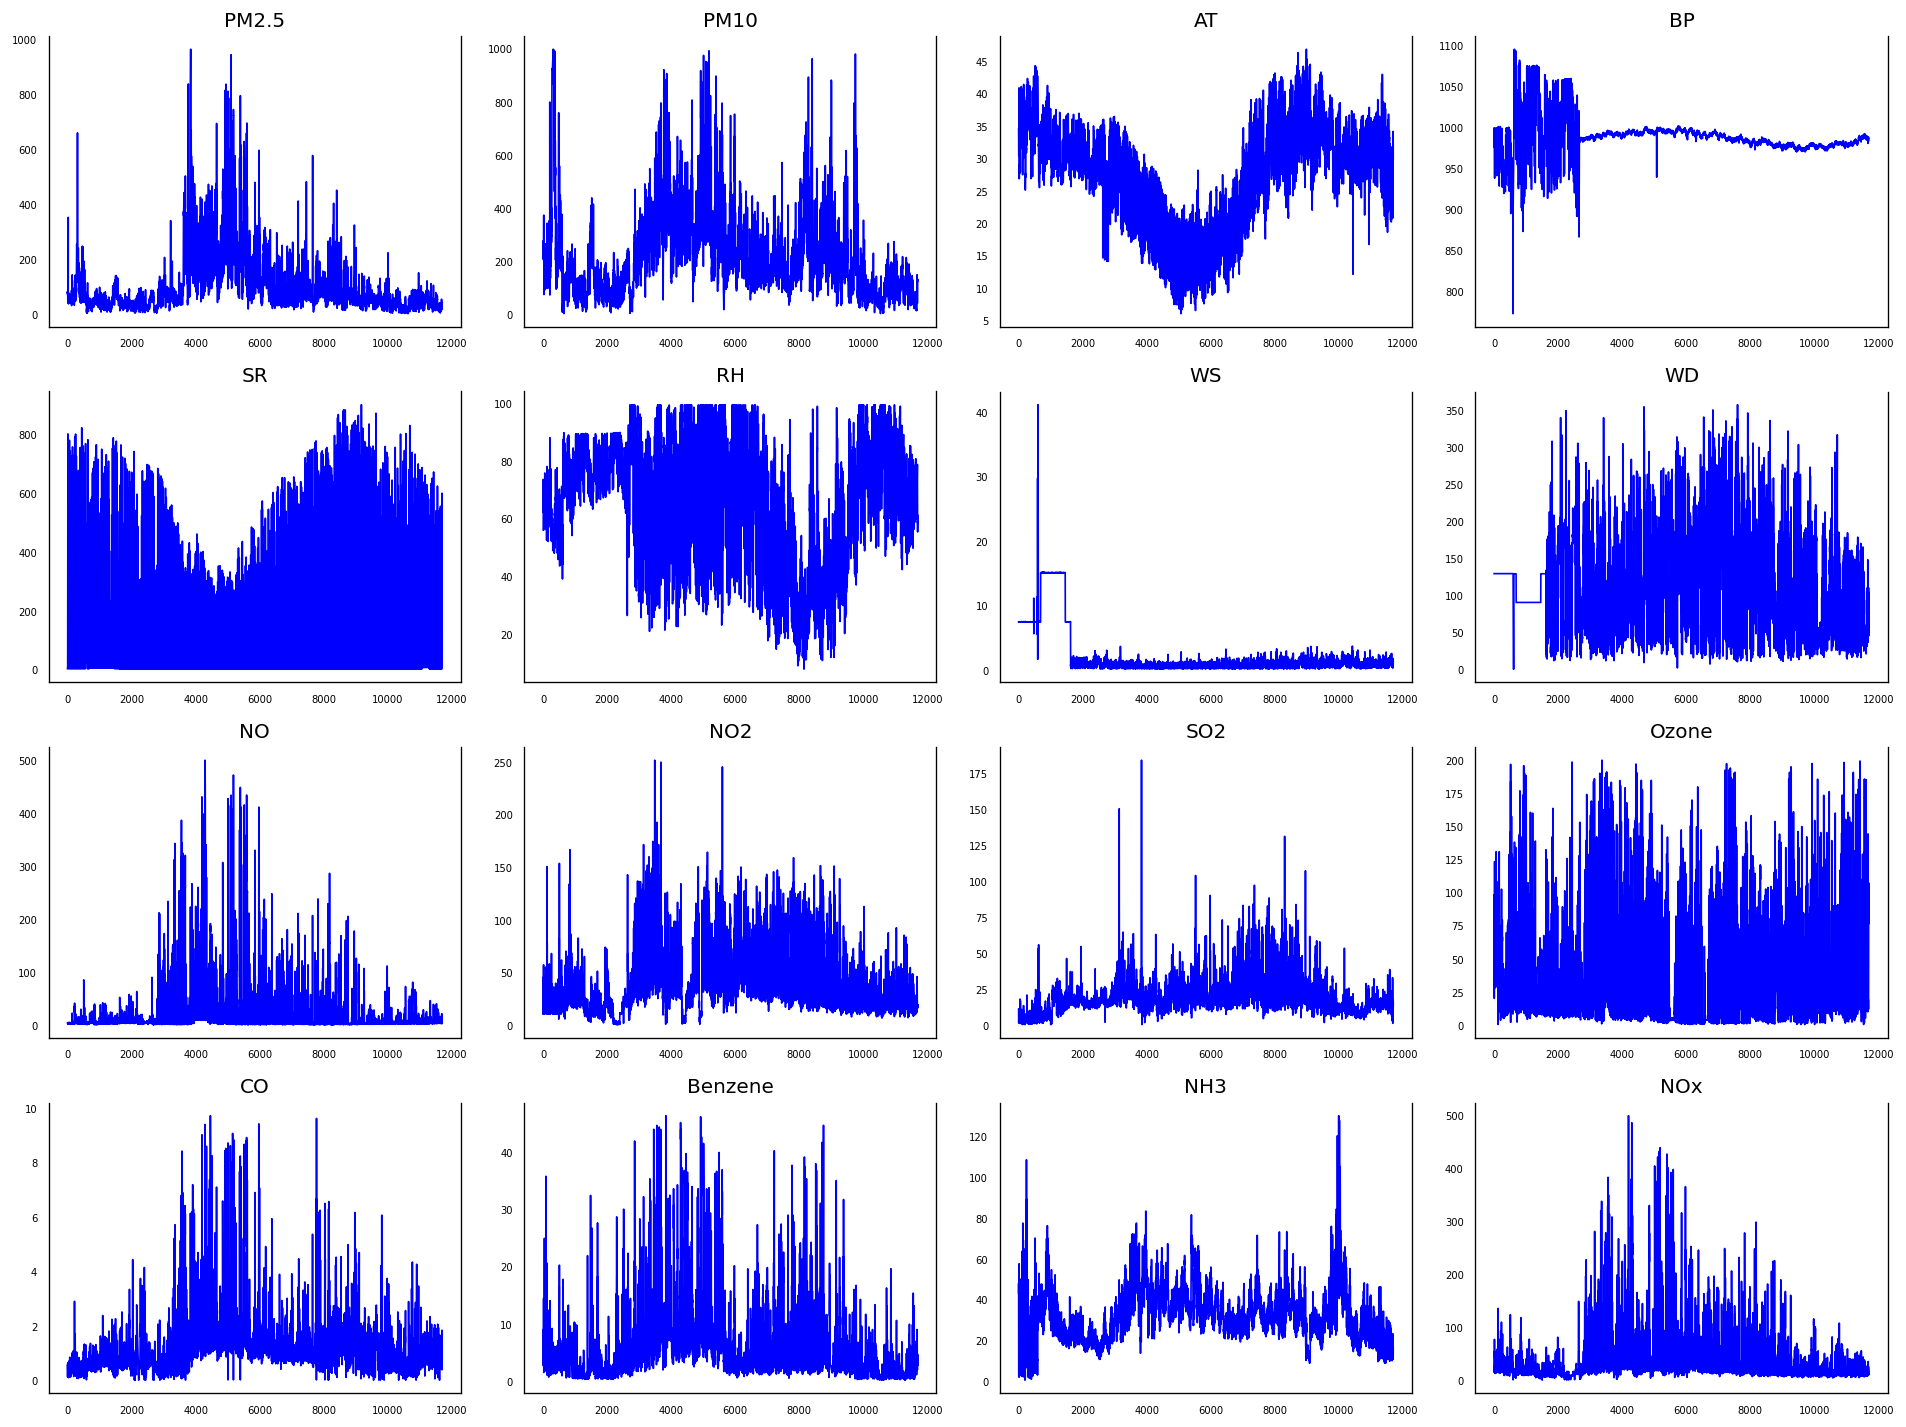

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, dpi=120, figsize=(16,12))
for i, ax in enumerate(axes.flatten()):
    datap = data[data.columns[i]]
    ax.plot(datap, color='blue', linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
data1=data.drop(['date'],axis=1)
data2=data['date']

In [ ]:
train = data1.iloc[:11681]
test = data1.iloc[11681:]

Using adfuller test which is used to analyse whether the data is a time series data or not.Generally p value of less than 0.5 signifies the correctness of your hypothesis.

In [ ]:
def ad_test(dataset):
  dftest=adfuller(dataset,autolag='AIC')
  print("2. P-Value : ",dftest[1])

In [ ]:
for i in data1.columns:
  ad_test(train[i])

2. P-Value :  6.47415278302343e-07
2. P-Value :  1.0295348120848764e-08
2. P-Value :  0.04918528061187918
2. P-Value :  5.229508768133587e-13
2. P-Value :  5.348280765592825e-15
2. P-Value :  1.6184269958399893e-05
2. P-Value :  0.13566369617321428
2. P-Value :  6.0011874076462276e-21
2. P-Value :  2.120294451742512e-18
2. P-Value :  2.0667108404745537e-09
2. P-Value :  3.605562815100417e-12
2. P-Value :  2.0655845629784295e-17
2. P-Value :  5.957719124090966e-14
2. P-Value :  4.989734657993711e-12
2. P-Value :  1.2732030571004804e-09
2. P-Value :  1.1251478359830538e-16


The lower p-values signifies the correctness of our hypothesis.It verifies the constant mean and seasonality of data.

Setting up ollama and downloading gemma:7b llm for zero-shot time series forecasting.

In [ ]:
llm = Ollama(model="gemma:7b")

In [ ]:
llm

Ollama(model='gemma:7b')

Run command in terminal-ollama serve & run gemma:7b in order to run llm model in your colab notebook.

Now doing prompting to do zero-shot time series forecasting using gemma:7b llm.

In [ ]:
llm.invoke("I have to do time series forecasting, can you do this task")

'I am not able to perform time series forecasting, as I do not have access to real-time data or engage in activities that require predictive modeling. However, I can provide you with resources and information about various time series forecasting techniques and algorithms. If you provide me with more information about your specific task and data, I may be able to help you in other ways.'

In [ ]:
llm.invoke("Okay I will provide you the data you just need to identify the pattern in the data and to the prediction just like sequence predictor")

'Sure, please provide me with the data you want me to analyze. I will then identify the pattern in the data and use that pattern to make predictions just like a sequence predictor.'

In [ ]:
llm.invoke("Just predict the next 24 numbers just like you predict the next words of sentences but use some statistical methods")

'Use some statistical methods to make the predictions'

In [ ]:
llm.invoke("Find the next 4 numbers using the sequence: [77,75,81,70,74,77,70,55,51,55]")

'The next 4 numbers in the sequence are 51, 55, 61, and 54.'

*   Actual data-67,63,68,61
*   There is significant error but large data may make right prediction.



Now predicting the data on the basis of previous 100 datapoint.

Creating a string of last 100 datapoints.

In [ ]:
string1=""
for i in range(len(data)):
    if i>11605:
     string1+=str(data.iloc[i,0])
     string1+=","

In [ ]:
string1

'9.5,10.5,9.75,11.75,12.5,16.75,16.5,17.75,15.75,12.25,16.5,25.75,26.0,37.25,32.25,25.0,26.5,23.5,29.75,35.25,38.0,39.75,25.0,17.5,12.0,10.75,17.0,18.5,15.5,21.25,26.0,30.0,29.25,15.0,6.0,5.0,2.25,3.5,6.75,11.0,7.25,6.75,11.25,11.0,17.5,19.0,21.25,27.25,24.25,21.0,17.0,14.0,14.75,17.75,19.25,17.0,16.75,14.25,10.75,13.75,8.25,11.25,8.5,9.75,16.5,14.5,22.75,24.5,25.5,34.5,37.5,34.25,38.75,42.25,47.0,51.25,52.5,47.5,53.0,45.25,38.75,32.5,26.5,28.0,20.25,24.0,21.5,14.5,18.25,26.0,28.5,25.25,19.75,22.75,34.5,37.5,41.25,39.0,39.25,'

In [ ]:
llm.invoke("Predict the next 24 numbers of the sequence:[9.5,10.5,9.75,11.75,12.5,16.75,16.5,17.75,15.75,12.25,16.5,25.75,26.0,37.25,32.25,25.0,26.5,23.5,29.75,35.25,38.0,39.75,25.0,17.5,12.0,10.75,17.0,18.5,15.5,21.25,26.0,30.0,29.25,15.0,6.0,5.0,2.25,3.5,6.75,11.0,7.25,6.75,11.25,11.0,17.5,19.0,21.25,27.25,24.25,21.0,17.0,14.0,14.75,17.75,19.25,17.0,16.75,14.25,10.75,13.75,8.25,11.25,8.5,9.75,16.5,14.5,22.75,24.5,25.5,34.5,37.5,34.25,38.75,42.25,47.0,51.25,52.5,47.5,53.0,45.25,38.75,32.5,26.5,28.0,20.25,24.0,21.5,14.5,18.25,26.0,28.5,25.25,19.75,22.75,34.5,37.5,41.25,39.0,39.25]")

'Sure, here is the next 24 numbers of the sequence:\n\n41.75, 42.5, 44.0, 50.25, 54.0, 51.25, 52.5, 48.0, 53.0, 52.0, 46.25, 48.75, 41.25, 38.25, 38.0, 36.25, 34.5, 31.5, 31.25, 28.25, 28.0, 26.5, 26.0, 26.5, 28.0, 22.25, 21.5, 18.0, 14.25, 12.0, 10.25, 12.25, 13.25, 11.25, 11.0, 10.5, 11.0, 10.0, 10.25, 12.0, 11.25, 10.0, 10.25, 12.0'

It is predicting more than 24 numbers but we will take the first 24 numbers.

In [ ]:
string2="41.75, 42.5, 44.0, 50.25, 54.0, 51.25, 52.5, 48.0, 53.0, 52.0, 46.25, 48.75, 41.25, 38.25, 38.0, 36.25, 34.5, 31.5, 31.25, 28.25, 28.0, 26.5, 26.0, 26.5"
predictions_list=string2.split(", ")
for i in range(len(predictions_list)):
  predictions_list[i]=float(predictions_list[i])
print(type(predictions_list[0]))

<class 'float'>


In [ ]:
test['Predictions1']=predictions_list

<ipython-input-87-485cb8e7a307>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions1']=predictions_list


In [ ]:
test['Predictions1']

11681    41.75
11682    42.50
11683    44.00
11684    50.25
11685    54.00
11686    51.25
11687    52.50
11688    48.00
11689    53.00
11690    52.00
11691    46.25
11692    48.75
11693    41.25
11694    38.25
11695    38.00
11696    36.25
11697    34.50
11698    31.50
11699    31.25
11700    28.25
11701    28.00
11702    26.50
11703    26.00
11704    26.50
Name: Predictions1, dtype: float64

In [ ]:
evaluation_dataset=test[['PM2.5','Predictions1']]
evaluation_dataset.reset_index(drop=True,inplace=True)
print(evaluation_dataset)

    PM2.5  Predictions1
0   51.25         41.75
1   52.50         42.50
2   47.50         44.00
3   53.00         50.25
4   45.25         54.00
5   38.75         51.25
6   32.50         52.50
7   26.50         48.00
8   28.00         53.00
9   20.25         52.00
10  24.00         46.25
11  21.50         48.75
12  14.50         41.25
13  18.25         38.25
14  26.00         38.00
15  28.50         36.25
16  25.25         34.50
17  19.75         31.50
18  22.75         31.25
19  34.50         28.25
20  37.50         28.00
21  41.25         26.50
22  39.00         26.00
23  39.25         26.50


In [ ]:
evaluation_dataset['PM2.5']

0     51.25
1     52.50
2     47.50
3     53.00
4     45.25
5     38.75
6     32.50
7     26.50
8     28.00
9     20.25
10    24.00
11    21.50
12    14.50
13    18.25
14    26.00
15    28.50
16    25.25
17    19.75
18    22.75
19    34.50
20    37.50
21    41.25
22    39.00
23    39.25
Name: PM2.5, dtype: float64

<Axes: >

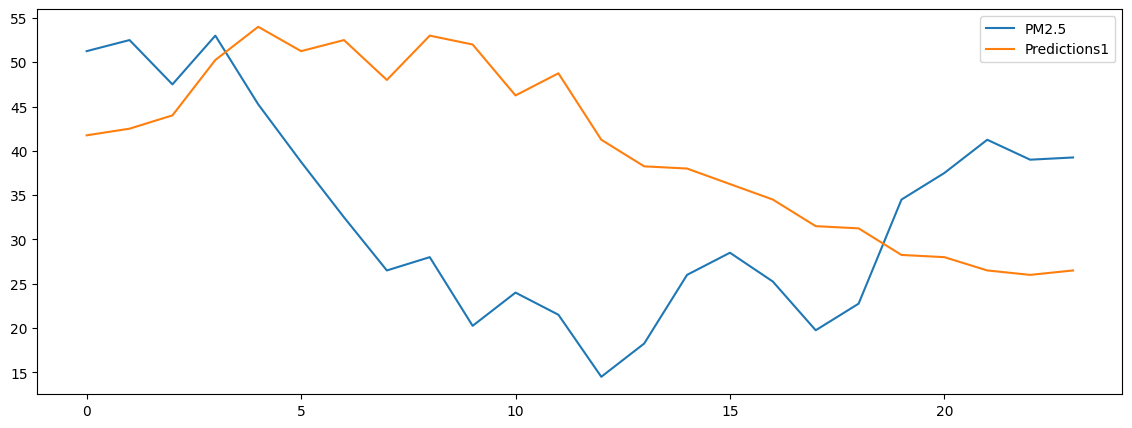

In [ ]:
evaluation_dataset.plot(figsize=(14,5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(evaluation_dataset['PM2.5'],evaluation_dataset['Predictions1']))
print(rmse)

16.418675849978484


Since we are using zero-shot approach and model is not trained on time series data,it is not giving better results.

Now preparing the data for using in LSTM model for time series forcasting using LSTM.

In [ ]:
train = data1.iloc[:11681]
test = data1.iloc[11681:]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train
list1=[]
for i in range(len(scaled_train)):
    list1.append(scaled_train[i][0])
list1=np.array(list1)
print(list1)

[0.07963684 0.07756161 0.08378729 ... 0.03994812 0.04357977 0.04850843]


In [ ]:
# define generator
n_input = 400
n_features = 16
generator = TimeseriesGenerator(scaled_train, list1, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               46800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 46901 (183.21 KB)
Trainable params: 46901 (183.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [106]:
# fit model
model.fit(generator,epochs=20)

Epoch 1/20
11281/11281 [==============================] - 2359s 209ms/step - loss: 6.9433e-04
Epoch 2/20
11281/11281 [==============================] - 2335s 207ms/step - loss: 5.2479e-04
Epoch 3/20
11281/11281 [==============================] - 2357s 209ms/step - loss: 4.8955e-04
Epoch 4/20
11281/11281 [==============================] - 2348s 208ms/step - loss: 4.5934e-04
Epoch 5/20
11281/11281 [==============================] - 2384s 211ms/step - loss: 4.3623e-04
Epoch 6/20
11281/11281 [==============================] - 2304s 204ms/step - loss: 4.2094e-04
Epoch 7/20
11281/11281 [==============================] - 2314s 205ms/step - loss: 4.1291e-04
Epoch 8/20
11281/11281 [==============================] - 2356s 209ms/step - loss: 3.9575e-04
Epoch 9/20
11281/11281 [==============================] - 2338s 207ms/step - loss: 3.9957e-04
Epoch 10/20
11281/11281 [==============================] - 2335s 207ms/step - loss: 3.8875e-04
Epoch 11/20
11281/11281 [==============================] - 

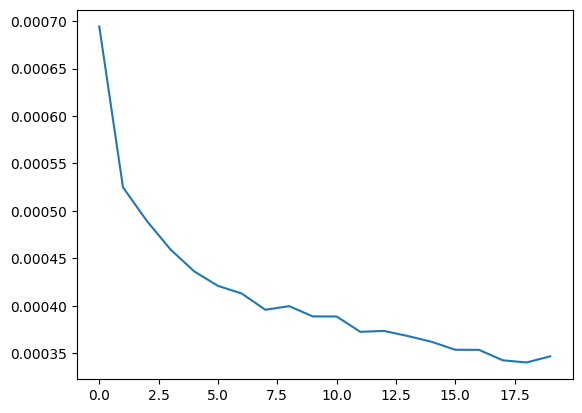

In [107]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Creating a window size of 400.

In [108]:
last_train_batch = scaled_train[-400:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 1s 776ms/step


array([[0.05721192]], dtype=float32)

In [109]:
list2=[]
scaler_list=[]
for i in range(len(scaled_test)):
    list2.append(scaled_test[i][0])
    scaler_list.append(test.iloc[i,0])
list2=np.array(list2)
scaler_list=np.array(scaler_list)
print(list2)

[0.05291829 0.0542153  0.04902724 0.05473411 0.04669261 0.03994812
 0.03346304 0.02723735 0.02879377 0.02075227 0.02464332 0.02204929
 0.01478599 0.01867704 0.02671855 0.02931258 0.02594034 0.02023346
 0.0233463  0.03553826 0.0386511  0.04254215 0.04020752 0.04046693]


Creating another scaler to convert back to the predicted scaled value to the originally scaled values.

In [110]:
scaler2=MinMaxScaler()
scaler_list=scaler_list.reshape(24,1)
scaler2.fit(scaler_list)

MinMaxScaler()

In [111]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(list2)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    #making the new batch
    new_batch = []
    new_batch.extend(scaled_test[i])
    new_batch[0]=float(current_pred)
    new_batch = np.array(new_batch)
    new_batch=new_batch.reshape((1, 1, n_features))
    current_batch = np.hstack((current_batch[:,1:,:],new_batch))

1/1 [==============================] - 0s 115ms/step


<ipython-input-111-8d69a5a7491e>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_batch[0]=float(current_pred)


1/1 [==============================] - 0s 72ms/step


In [112]:
true_predictions = scaler2.inverse_transform(test_predictions)

In [113]:
evaluation_data = pd.DataFrame(true_predictions, columns=['Predictions'])
test.reset_index(inplace=True)
evaluation_data["PM2.5"]=test["PM2.5"]
print(test["PM2.5"])
print(evaluation_data)

0     51.25
1     52.50
2     47.50
3     53.00
4     45.25
5     38.75
6     32.50
7     26.50
8     28.00
9     20.25
10    24.00
11    21.50
12    14.50
13    18.25
14    26.00
15    28.50
16    25.25
17    19.75
18    22.75
19    34.50
20    37.50
21    41.25
22    39.00
23    39.25
Name: PM2.5, dtype: float64
    Predictions  PM2.5
0     16.702659  51.25
1     16.989261  52.50
2     17.357109  47.50
3     17.627613  53.00
4     17.930919  45.25
5     17.893321  38.75
6     17.862469  32.50
7     18.075577  26.50
8     18.118640  28.00
9     18.194755  20.25
10    18.043361  24.00
11    17.994021  21.50
12    17.884273  14.50
13    17.861485  18.25
14    18.108135  26.00
15    18.483913  28.50
16    18.376319  25.25
17    18.040128  19.75
18    17.891670  22.75
19    17.766750  34.50
20    17.690040  37.50
21    17.642031  41.25
22    17.685859  39.00
23    17.664286  39.25


<Axes: >

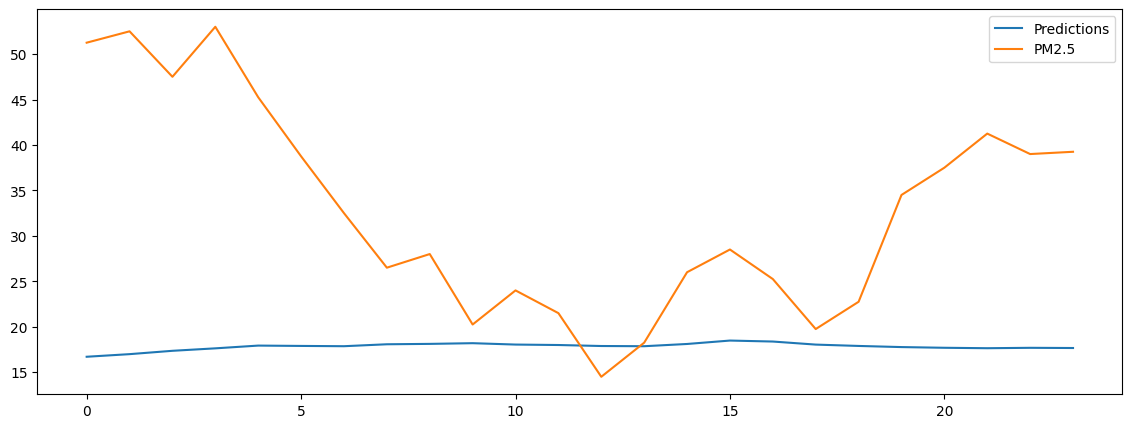

In [114]:
evaluation_data.plot(figsize=(14,5))

In [115]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(evaluation_data['PM2.5'],evaluation_data['Predictions']))
print(rmse)

18.961058174797913


Now using ARIMA model for time series forcasting.

In [119]:
stepwise_fit = auto_arima(data['PM2.5'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=105486.390, Time=54.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=109961.891, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=106932.691, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=106292.831, Time=4.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=109959.891, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=28.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=106222.418, Time=10.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=105439.376, Time=44.00 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=106222.723, Time=16.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=105365.298, Time=59.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=105378.386, Time=32.58 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=105381.705, Time=34.42 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=105375.617, Time=63.97 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=105485.985, Time=60.60 sec
 A

In [129]:
model =smt.arima.ARIMA(train['PM2.5'], order=(3, 1, 4))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                11681
Model:                 ARIMA(3, 1, 4)   Log Likelihood              -52554.087
Date:                Mon, 04 Mar 2024   AIC                         105124.174
Time:                        13:29:10   BIC                         105183.099
Sample:                             0   HQIC                        105143.967
                              - 11681                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9487      0.026     35.984      0.000       0.897       1.000
ar.L2          0.6923      0.044     15.611      0.000       0.605       0.779
ar.L3         -0.7496      0.021    -35.552      0.000      -0.791      -0.708
ma.L1         -0.4100      0.026    -15.527      0.000      -0.462      -0.358
ma.L2         -1.2411      0.031    -40.658      0.000      -1.301      -1.181
ma.L3          0.2995      0.006     48.002      0.000       0.287       0.312
ma.L4          0.4177      0.010     43.055      0.000       0.399       0.437
sigma2       473.9020      1.322    358.580      0.000     471.312     476.492
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1318685.88
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

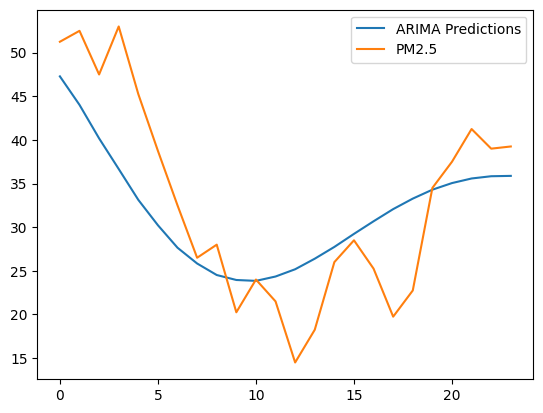

In [136]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred=pred.to_frame()
pred.reset_index(inplace=True)
pred.drop('index',axis=1,inplace=True)
pred.plot(legend=True)
test['PM2.5'].plot(legend=True)

In [137]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['PM2.5'].mean()
rmse=sqrt(mean_squared_error(pred,test['PM2.5']))
print(rmse)

7.13221263288053


rmse values

*   gemma:7b model-16.42
*   LSTM -18.96
*   ARIMA-7.13





Insights-

*   Best performance is shown by ARIMA model as it is a statistical approach used for time series forcasting.
*   It is observed LSTM is predicting in almost straight line it might be because of constant mean of data and after training on more than 11000 datapoints having a constant mean it is predicting next 24 dataset with constant mean and low variance hence not able to fit the actual values.LSTM are not performing better due to their linear prediction
*   LLM is performing better than LSTM and that too on zero shot prediction and that too when gemma:7b is not particularly trained on time series data,it shows the scope of using llms for time series forcasting.





Special remarks-Using TimeLLM a llm specifically used in time series forcasting can give amazing results but it is not an api available at ollama or other plateforms. It is based on the general approach of converting time series data into text data on which llms can work better and predict the next words and then changing it back to numerical data.